## Configuration de l'environnement

D'abord, nous importons les bibliothèques nécessaires. tensorflow et tensorflow_datasets (tfds) seront nos outils principaux pour charger les données. matplotlib et numpy nous serviront pour la visualisation et les manipulations de base.

In [38]:
import sys
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

print(sys.version)
print("TensorFlow Version:", tf.__version__)
print("TF Datasets Version:", tfds.__version__)
print("Keras Version:", tf.keras.__version__)
print("Matplotlib Version:", matplotlib.__version__)
print("Numpy Version:", np.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-learn version:", sklearn.__version__)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow Version: 2.18.0
TF Datasets Version: 4.9.9
Keras Version: 3.8.0
Matplotlib Version: 3.7.2
Numpy Version: 1.26.4
Seaborn version: 0.12.2
Scikit-learn version: 1.2.2


## Chargement du dataset plant_village

## Préparation et Analyse de Données

In [39]:
# Nombre total d'exemples dans le jeu de données
DATA_DIR = '/kaggle/input/plantdisease/PlantVillage'


# Charger le dataset avec Keras
dataset = image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical', 
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 20638 files belonging to 15 classes.


### Analyse de la Distribution des Classes
*Il est important de vérifier si les classes sont équilibrées. Un fort déséquilibre pourrait biaiser l'entraînement du modèle, qui aurait tendance à mieux prédire les classes majoritaires.*

In [3]:
# Obtenir les noms des classes
class_names = dataset.class_names
num_classes = len(class_names)

print(f"Nombre de classes: {num_classes}")
print(f"Noms des classes: {class_names}")

# Compter le nombre total d'images
num_examples = 0
for _ in dataset:
    num_examples += 1
num_examples *= 32  # batch_size
print(f"Nombre estimé d'images: {num_examples}")

Nombre de classes: 15
Noms des classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Nombre estimé d'images: 20640


In [4]:
from collections import Counter

class_names = dataset.class_names

class_counter = Counter()

for _, labels in dataset:
    class_indices = tf.argmax(labels, axis=1).numpy()
    class_counter.update(class_names[idx] for idx in class_indices)

print("\nDistribution des classes :")
for class_name, count in class_counter.most_common():
    print(f"- {class_name}: {count} images")


Distribution des classes :
- Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images
- Tomato_Bacterial_spot: 2127 images
- Tomato_Late_blight: 1909 images
- Tomato_Septoria_leaf_spot: 1771 images
- Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
- Tomato_healthy: 1591 images
- Pepper__bell___healthy: 1478 images
- Tomato__Target_Spot: 1404 images
- Potato___Early_blight: 1000 images
- Tomato_Early_blight: 1000 images
- Potato___Late_blight: 1000 images
- Pepper__bell___Bacterial_spot: 997 images
- Tomato_Leaf_Mold: 952 images
- Tomato__Tomato_mosaic_virus: 373 images
- Potato___healthy: 152 images


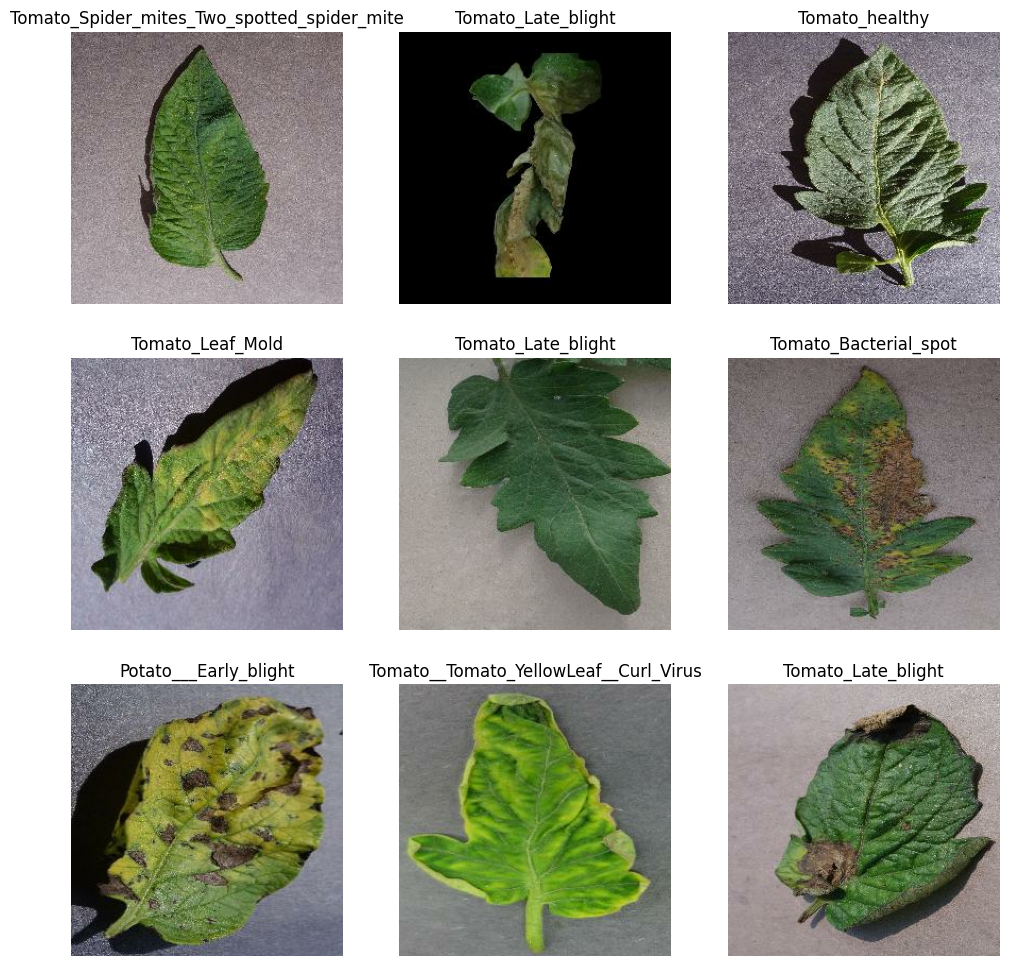

In [5]:
# Fonction pour obtenir le nom du label à partir de son index
def get_label_name(label_tensor):
      return class_names[tf.argmax(label_tensor).numpy()]


# Afficher quelques images
plt.figure(figsize=(12, 12))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(get_label_name(labels[i]))
        plt.axis("off")
plt.show()

In [40]:
# Chargement direct avec les bonnes proportions
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
SEED = 42

# Charger les données en créant un jeu de validation (qui sera divisé en deux)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical', # Important pour la fonction de perte
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    #batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    #batch_size=BATCH_SIZE
)

# Diviser le jeu de 20% en 10% pour la validation et 10% pour le test
val_batches = tf.data.experimental.cardinality(val_test_ds)
val_ds = val_test_ds.take(val_batches // 2)
test_ds = val_test_ds.skip(val_batches // 2)

# Informations sur le jeu de données
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Nombre de classes: {num_classes}")
print(f"Nombre de batches d'entraînement: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Nombre de batches de validation:   {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Nombre de batches de test:         {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Nombre de classes: 15
Nombre de batches d'entraînement: 516
Nombre de batches de validation:   64
Nombre de batches de test:         65


## Construction du Pipeline de Données (Pré-traitement)
Un pipeline de données efficace est crucial pour l'entraînement d'un modèle. Il permet de traiter les données à la volée, d'optimiser l'utilisation du GPU et de s'assurer que les données sont dans le bon format. Nous allons effectuer les opérations suivantes :


1. Redimensionnement et Normalisation : Uniformiser la taille des images et mettre leurs pixels à l'échelle.
2. Augmentation des Données (Data Augmentation) : Appliquer des transformations aléatoires sur le jeu d'entraînement.
3. Mise en Lots et Pré-chargement (Batching & Prefetching) : Organiser les données en lots et préparer les lots suivants pendant que le GPU travaille, afin d'éviter les temps morts.


In [7]:
# Définir les paramètres
IMG_SIZE = 256
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE # Permet à TensorFlow d'optimiser le pipeline dynamiquement


# Les couches de prétraitement restent les mêmes
rescale = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),

])


# Fonction de prétraitement pour une image unique
def preprocess_train_image(image, label):
    image = rescale(image)
    image = data_augmentation(image, training=True)
    return image, label

def preprocess_val_test_image(image, label):
    image = rescale(image)
    return image, label


In [8]:
# --- Construction du pipeline optimisé ---

# Pipeline d'entraînement
train_ds = train_ds.map(preprocess_train_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=1000)
#train_ds = train_ds.batch(BATCH_SIZE)  # On met en lots ICI
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Pipeline de validation
val_ds = val_ds.map(preprocess_val_test_image, num_parallel_calls=AUTOTUNE)
#val_ds = val_ds.batch(BATCH_SIZE)      # On met en lots ICI
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Pipeline de test
test_ds = test_ds.map(preprocess_val_test_image, num_parallel_calls=AUTOTUNE)
#test_ds = test_ds.batch(BATCH_SIZE)      # On met en lots ICI
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Construction du Modèle de Classification (CNN)

In [19]:
model = tf.keras.Sequential([
    # Couche d'entrée
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Premier bloc convolutionnel
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),  

    # Deuxième bloc convolutionnel
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),  

    # Troisième bloc convolutionnel
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),  

    # Partie classification (tête du modèle)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,621,455 (113.00 MB)

 Trainable params: 29,620,495 (112.99 MB)

 Non-trainable params: 960 (3.75 KB)

### Compilation du Modèle


In [29]:
# On définit un taux d'apprentissage. 0.0001 est une valeur commune pour un apprentissage plus stable.
LEARNING_RATE = 0.01

# On crée une instance de l'optimiseur Adam en lui passant notre taux d'apprentissage
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy',
    ]
)


## L'entraînement

In [30]:
print("\n--- Lancement de l'entraînement ---")
EPOCHS = 36

# Avant model.fit(), ajouter :
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
]

# Modifier l'entraînement :
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("--- Entraînement terminé ---")


--- Lancement de l'entraînement ---
Epoch 1/36
516/516 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.4627 - loss: 6.0729 - val_accuracy: 0.2798 - val_loss: 5.9511 - learning_rate: 0.0100
Epoch 2/36
516/516 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.5368 - loss: 4.9758 - val_accuracy: 0.5806 - val_loss: 4.8246 - learning_rate: 0.0100
Epoch 3/36
516/516 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.5651 - loss: 4.6313 - val_accuracy: 0.3232 - val_loss: 7.4537 - learning_rate: 0.0100
Epoch 4/36
516/516 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.5945 - loss: 4.5587 - val_accuracy: 0.5625 - val_loss: 4.7558 - learning_rate: 0.0100
Epoch 5/36
516/516 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.6264 - loss: 4.1964 - val_accuracy: 0.6094 - val_loss: 4.1575 - learning_rate: 0.0100
Epoch 6/36
516/516 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.6339 - loss: 4.1993 - val_accuracy: 0.3911 - val_loss: 8.5448 - learning_rate: 0.0100
Epoch 7/36
516/516 ━━━━━━━━━━━━━━━━━━━━

###  Préparation des prédictions et des vrais labels



--- Génération des courbes d'apprentissage ---


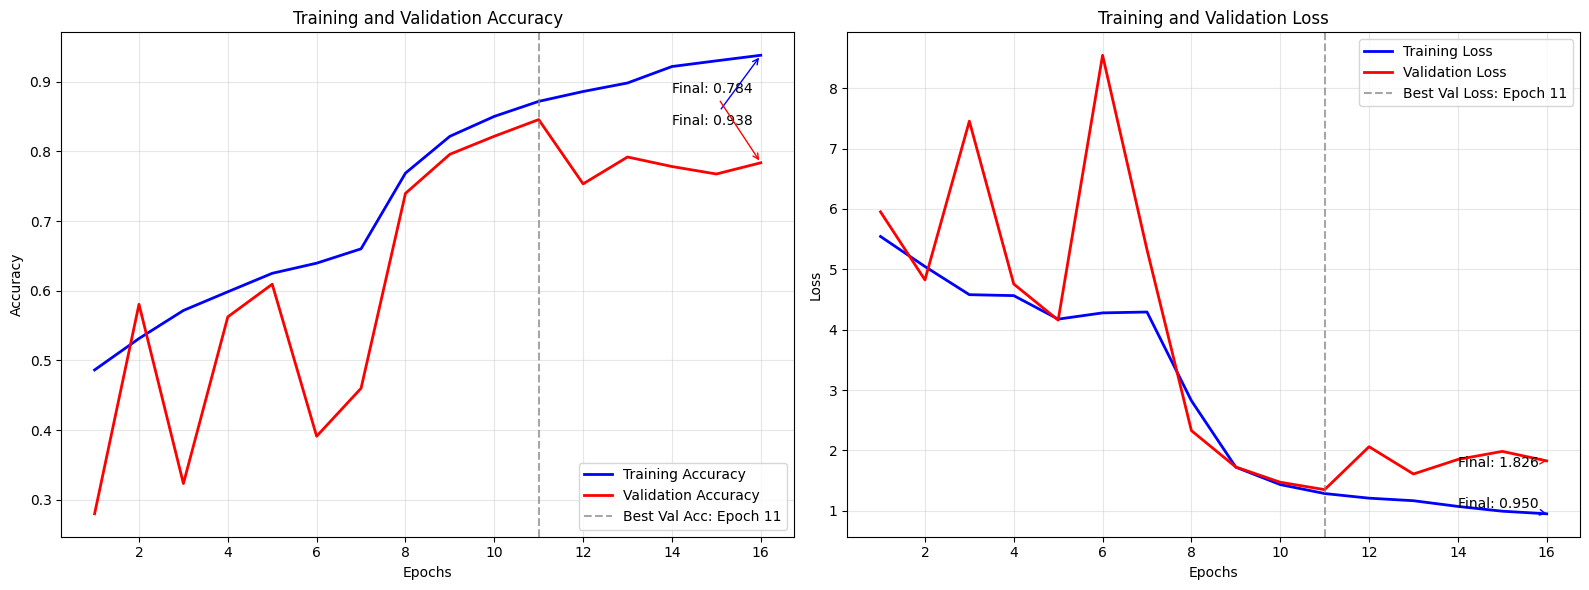


--- Résumé des Performances ---
Meilleure précision validation: 0.846 (Époque 11)
Meilleure loss validation: 1.350 (Époque 11)
Précision finale entraînement: 0.938
Précision finale validation: 0.784
Différence train/val: 0.154
📊 Performance équilibrée


In [31]:
print("\n--- Génération des courbes d'apprentissage ---")

# Utiliser la longueur réelle de l'historique (au cas où l'entraînement s'arrêterait plus tôt)
actual_epochs = len(history.history['accuracy'])
epochs_range = range(1, actual_epochs + 1)

# Récupérer les métriques
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculer les meilleures époques
best_epoch_acc = np.argmax(val_acc) + 1
best_epoch_loss = np.argmin(val_loss) + 1

plt.figure(figsize=(16, 6))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
plt.axvline(x=best_epoch_acc, color='gray', linestyle='--', alpha=0.7, 
            label=f'Best Val Acc: Epoch {best_epoch_acc}')


# Ajouter des annotations pour les dernières valeurs
last_acc = acc[-1]
last_val_acc = val_acc[-1]
plt.annotate(f'Final: {last_acc:.3f}', 
             xy=(actual_epochs, last_acc), 
             xytext=(actual_epochs-2, last_acc-0.1),
             arrowprops=dict(arrowstyle='->', color='blue'))
plt.annotate(f'Final: {last_val_acc:.3f}', 
             xy=(actual_epochs, last_val_acc), 
             xytext=(actual_epochs-2, last_val_acc+0.1),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

# Courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
plt.axvline(x=best_epoch_loss, color='gray', linestyle='--', alpha=0.7,
            label=f'Best Val Loss: Epoch {best_epoch_loss}')

# Ajouter des annotations pour les dernières valeurs
last_loss = loss[-1]
last_val_loss = val_loss[-1]
plt.annotate(f'Final: {last_loss:.3f}', 
             xy=(actual_epochs, last_loss), 
             xytext=(actual_epochs-2, last_loss+0.1),
             arrowprops=dict(arrowstyle='->', color='blue'))
plt.annotate(f'Final: {last_val_loss:.3f}', 
             xy=(actual_epochs, last_val_loss), 
             xytext=(actual_epochs-2, last_val_loss-0.1),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Afficher un résumé des performances
print(f"\n--- Résumé des Performances ---")
print(f"Meilleure précision validation: {max(val_acc):.3f} (Époque {best_epoch_acc})")
print(f"Meilleure loss validation: {min(val_loss):.3f} (Époque {best_epoch_loss})")
print(f"Précision finale entraînement: {acc[-1]:.3f}")
print(f"Précision finale validation: {val_acc[-1]:.3f}")
print(f"Différence train/val: {acc[-1] - val_acc[-1]:.3f}")

# Analyser le surapprentissage (overfitting)
if val_acc[-1] < acc[-1] - 0.16:  # Différence de plus de 16%
    print("⚠️  Signe possible de surapprentissage (overfitting)")
elif val_acc[-1] > acc[-1]:
    print("✅ Bonne généralisation")
else:
    print("📊 Performance équilibrée")

In [32]:
y_true = []
y_pred_probs = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred = np.argmax(y_pred_probs, axis=1)

In [33]:
# Évaluation corrigée
print("\\n--- Évaluation sur le jeu de test ---")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2%}")

\n--- Évaluation sur le jeu de test ---
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8598 - loss: 1.3203
Test Accuracy: 86.24%


In [34]:

# Prédictions pour la matrice de confusion
y_true = []
y_pred = []

for images, labels in test_ds:
    # True labels (convertir one-hot en indices)
    true_indices = tf.argmax(labels, axis=1)
    y_true.extend(true_indices.numpy())
    
    # Predictions
    predictions = model.predict(images, verbose=0)
    pred_indices = tf.argmax(predictions, axis=1)
    y_pred.extend(pred_indices.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [35]:
# Générer le rapport de classification détaillé
print("\nRapport de Classification Détaillé :")
print(classification_report(y_true, y_pred, target_names=class_names))


Rapport de Classification Détaillé :
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.83      0.88       101
                     Pepper__bell___healthy       0.87      0.96      0.92       152
                      Potato___Early_blight       0.75      0.99      0.85       101
                       Potato___Late_blight       0.88      0.70      0.78        92
                           Potato___healthy       0.86      0.40      0.55        15
                      Tomato_Bacterial_spot       0.82      0.97      0.89       226
                        Tomato_Early_blight       0.84      0.62      0.71       102
                         Tomato_Late_blight       0.86      0.88      0.87       200
                           Tomato_Leaf_Mold       0.78      0.91      0.84        88
                  Tomato_Septoria_leaf_spot       0.93      0.61      0.73       184
Tomato_Spider_mites_Two_sp

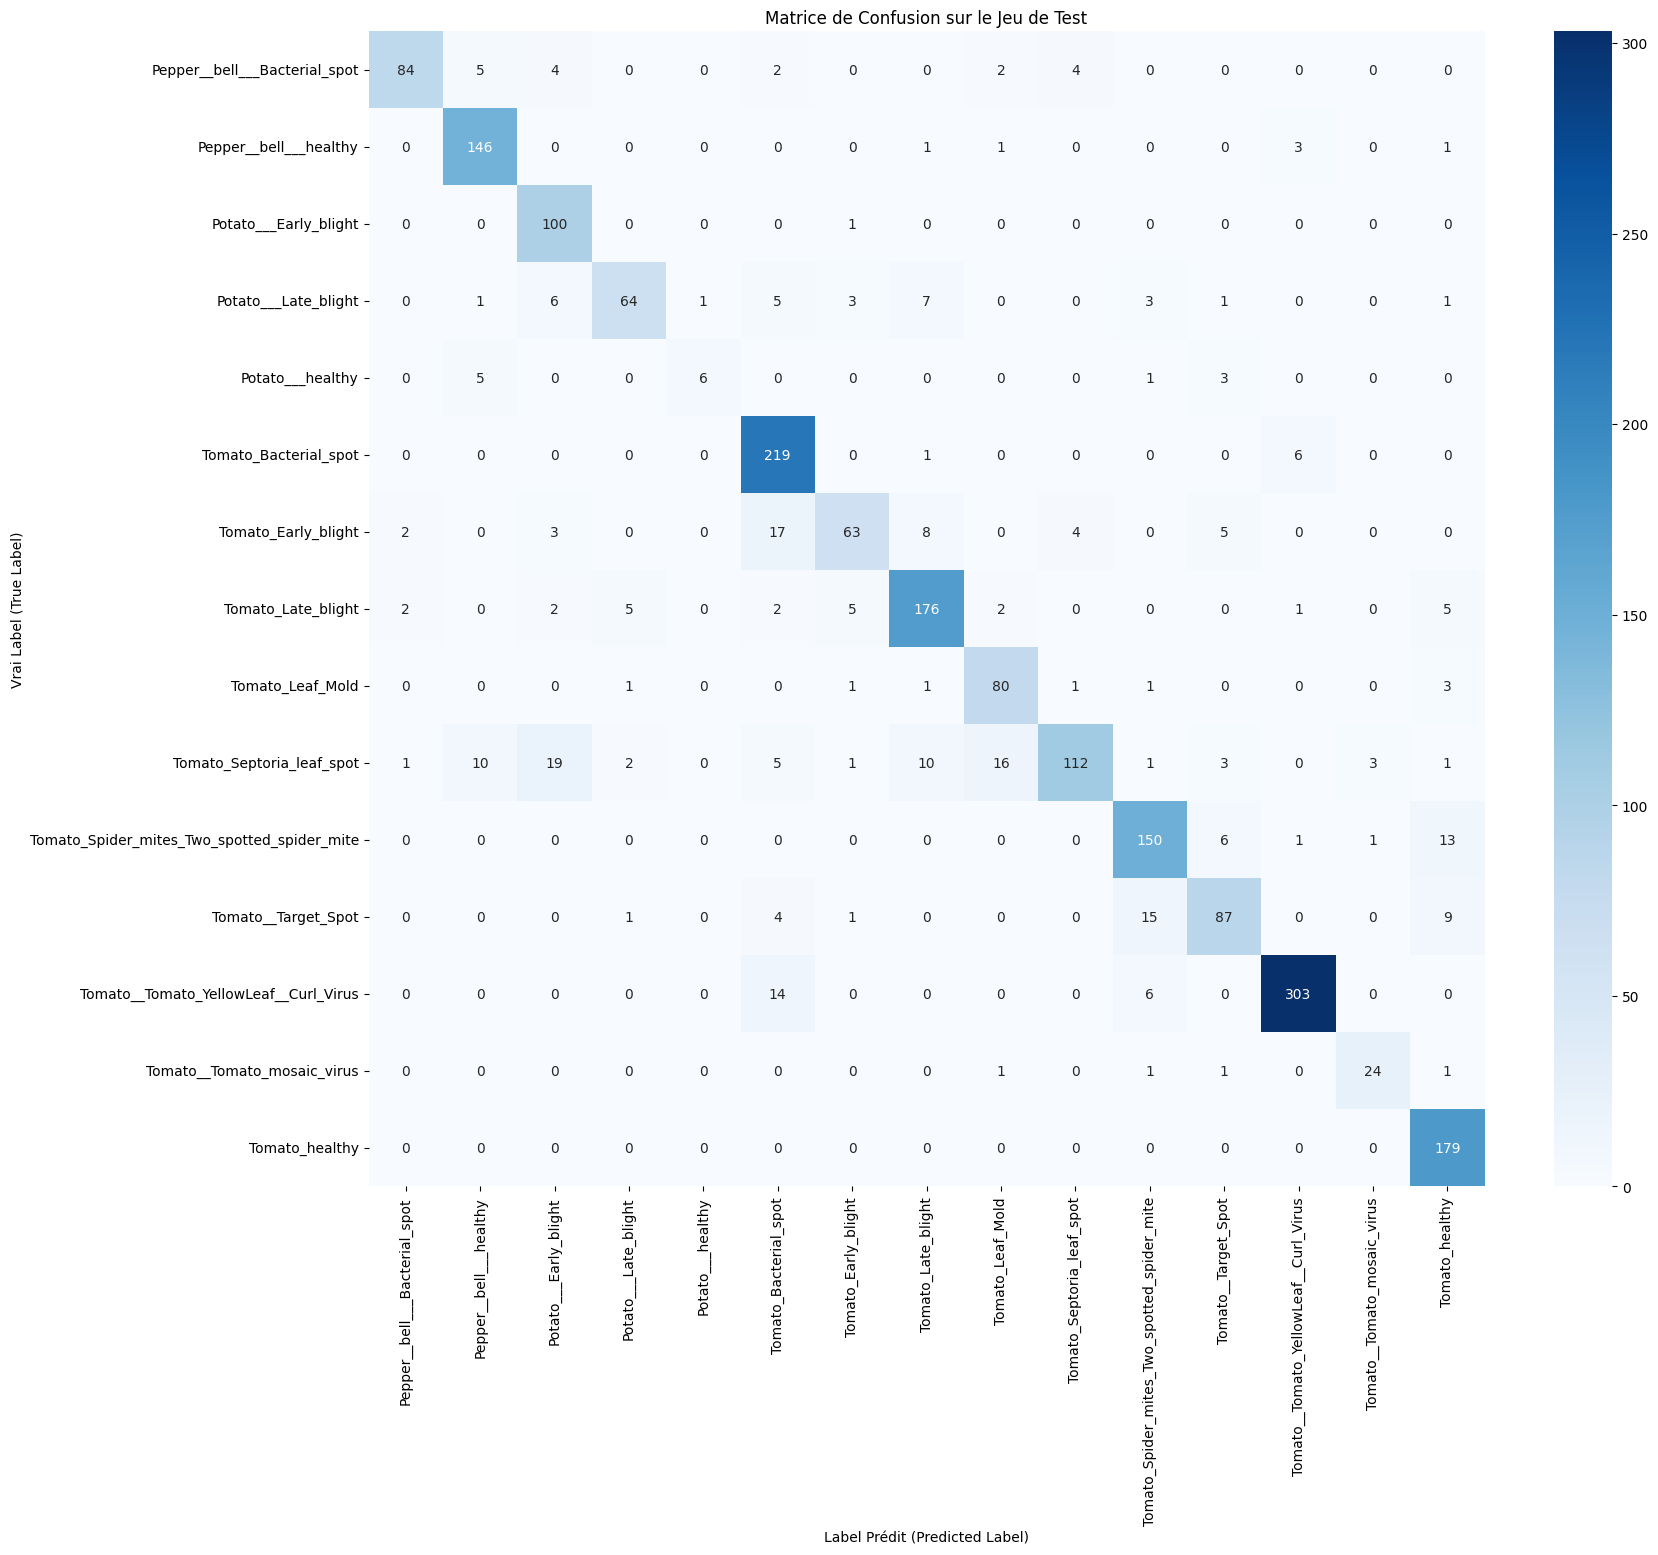

In [36]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion sous forme de heatmap pour une meilleure lisibilité
plt.figure(figsize=(18, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion sur le Jeu de Test')
plt.ylabel('Vrai Label (True Label)')
plt.xlabel('Label Prédit (Predicted Label)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


--- Génération des courbes d'apprentissage ---


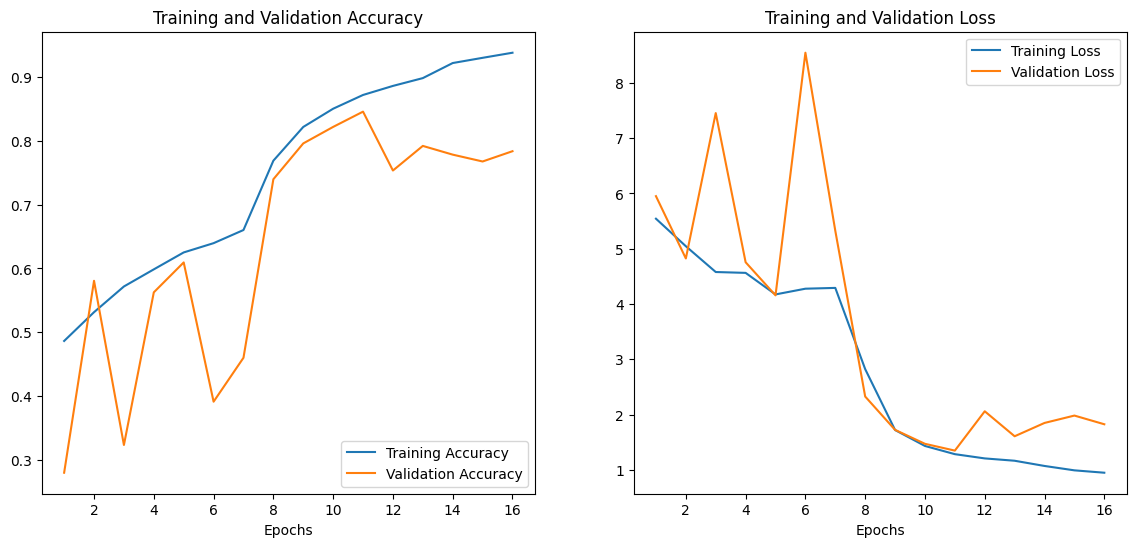

Époques effectives: 16


In [37]:
print("\n--- Génération des courbes d'apprentissage ---")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Utiliser le nombre réel d'époques au lieu d'EPOCHS
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.show()

print(f"Époques effectives: {len(acc)}")